In [12]:
import matplotlib.pyplot as plt
import numpy as np
from argparse import Namespace

import torch
import torch.nn.functional as F
import pytorch3d 
import pytorch3d.transforms as T3
from pytorch3d.structures import Pointclouds
import pytorch_lightning as pl

from src.config import get_parser
from src.renderer import Renderer
from src.util import make_faces

In [53]:
config.viewpoint_distance = 1.25

In [79]:
config = get_parser().parse_args(args=[])
config.viewpoint_distance = 1.25
print(config)
device = torch.device("cuda")
renderer = Renderer(config)
renderer = renderer.to(device)
renderer

Namespace(D_act_name='Swish', D_filters=[3, 32, 64], D_num_outcomes=32, D_use_adaptive_reparam=True, D_use_spectral_norm=False, Dsteps=3, G_noise_amp=0.003, Gsteps=3, alpha=10, backbone='vgg11', beta1=0.5, blueprint='./data/blueprint127.npz', dlatent_size=128, gamma=0.1, in_channel=3, ker_size=3, lambda_grad=0.1, lights_location=[0.0, -1.0, 3.0], lr_d=0.0005, lr_g=0.0005, manualSeed=None, max_size=250, min_nfc=32, min_size=25, nc_im=3, nc_z=3, netD='', netG='', nfc=32, niter=2000, noise_amp=0.1, not_cuda=0, num_layer=5, out='Output', out_channel=32, padd_size=1, raster_image_size=512, raster_points_per_pixel=4, raster_radius=0.006, scale_factor=0.75, stride=1, viewpoint_azimuth=0.0, viewpoint_distance=1.25, viewpoint_elevation=0.0)


Renderer(
  (renderer): ShadingPointsRenderer(
    (rasterizer): PointsRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (compositor): ShadingCompositor(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

In [3]:
print(config.blueprint)
blueprint =  np.load(config.blueprint)
print(blueprint['points'].shape, blueprint['normals'].shape)
points = torch.tensor(blueprint['points'])
normals = torch.tensor(blueprint['normals'])
print(points.shape, normals.shape)

./data/blueprint127.npz
(1, 3, 256, 256) (1, 3, 256, 256)
torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


torch.Size([65536, 3]) torch.Size([65536, 3])


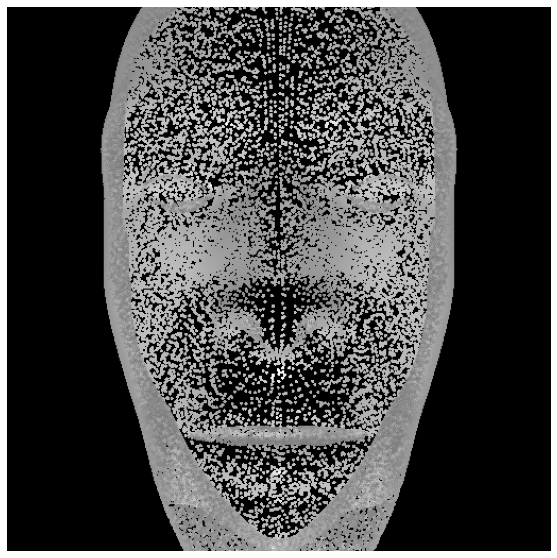

In [76]:
pt_points =  points[0].reshape(3, -1).t().to(device)
pt_normals =  normals[0].reshape(3, -1).t().to(device)
print(pt_normals.shape, pt_normals.shape)

rgb = torch.ones((pt_points.size(0), 4), device=device) - 0.3

point_cloud = Pointclouds(points=[pt_points], 
                          normals=[pt_normals],
                          features=[rgb])

images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [10]:
points[0].shape, points[0, :, 64:192, 64:192].shape

(torch.Size([3, 256, 256]), torch.Size([3, 128, 128]))

torch.Size([16384, 3]) torch.Size([16384, 3])


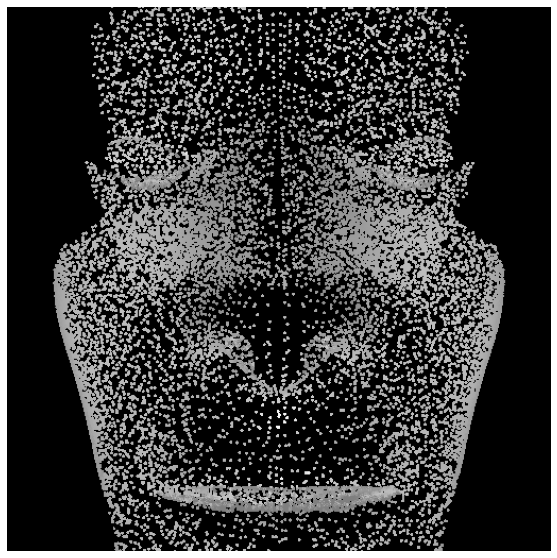

In [80]:
pt_points =  points[0, :, 64:192, 64:192].reshape(3, -1).t().to(device)
pt_normals =  normals[0, :, 64:192, 64:192].reshape(3, -1).t().to(device)
print(pt_normals.shape, pt_normals.shape)

rgb = torch.ones((pt_points.size(0), 4), device=device) - 0.3

point_cloud = Pointclouds(points=[pt_points], 
                          normals=[pt_normals],
                          features=[rgb])

images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [24]:
T = T3.Translate(torch.FloatTensor([[1.0, 2.0, 3.0]]))
R = T3.Rotate(torch.FloatTensor([
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [1.0, 0.0, 0.0],
]))
RT = T3.Transform3d().compose(R, T)
#T(torch.tensor([0., 0., 0.]))
(RT.transform_points(torch.tensor([[0., 0., 0.]])),
 RT.transform_normals(torch.tensor([[1., 0., 0.]])))

(tensor([[1., 2., 3.]]), tensor([[0., 1., 0.]]))

In [34]:
pt_points.mean(dim=0)[None]

tensor([[ 0.0006, -0.0062,  0.6028]], device='cuda:0')

torch.Size([16384, 3]) torch.Size([16384, 3])


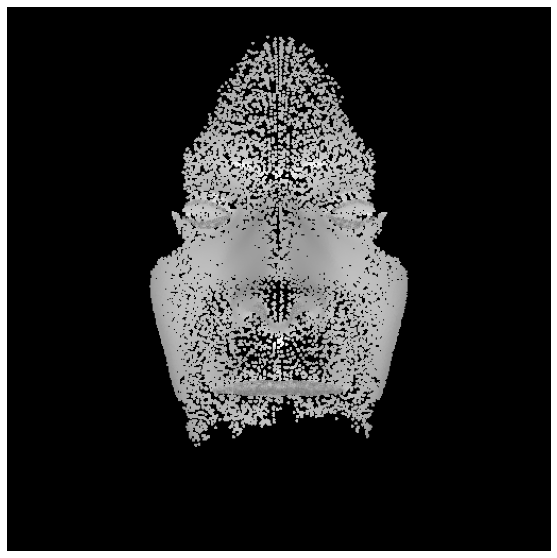

In [81]:
pt_points =  points[0, :, 64:192, 64:192].reshape(3, -1).t().to(device)
pt_normals =  normals[0, :, 64:192, 64:192].reshape(3, -1).t().to(device)
print(pt_points.shape, pt_normals.shape)

T = T3.Translate(-pt_points.mean(dim=0)[None]).to(device)

pt_points = T.transform_points(pt_points)
pt_normals = T.transform_normals(pt_normals)

rgb = torch.ones((pt_points.size(0), 4), device=device) - 0.3

point_cloud = Pointclouds(points=[pt_points], 
                          normals=[pt_normals],
                          features=[rgb])

images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [43]:
T = T3.Translate(pt_points.mean(dim=0)[None].to(device)).to(device)
T.transform_points(pt_points.to(device))

tensor([[-0.3689, -0.0205,  1.0732],
        [-0.3715, -0.0128,  1.0695],
        [-0.3716, -0.0234,  1.0684],
        ...,
        [ 0.3698,  0.0092,  1.0749],
        [ 0.3736,  0.0017,  1.0687],
        [ 0.3723, -0.0183,  1.0699]], device='cuda:0')

torch.Size([16384, 3]) torch.Size([16384, 3])


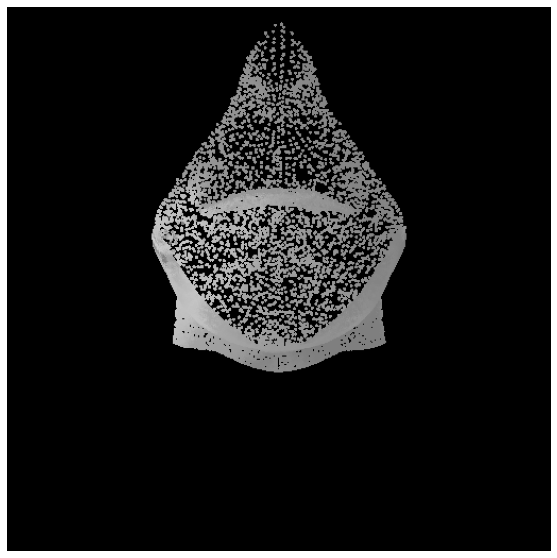

In [82]:
pt_points =  points[0, :, :128, 128:].reshape(3, -1).t().to(device)
pt_normals =  normals[0, :, 128:, 128:].reshape(3, -1).t().to(device)
print(pt_points.shape, pt_normals.shape)

T = T3.Translate(-pt_points.mean(dim=0)[None]).to(device)

pt_points = T.transform_points(pt_points)
pt_normals = T.transform_normals(pt_normals)

rgb = torch.ones((pt_points.size(0), 4), device=device) - 0.3

point_cloud = Pointclouds(points=[pt_points], 
                          normals=[pt_normals],
                          features=[rgb])

images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");